In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import pickle
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Dict, Set, Tuple
import warnings
import re
warnings.filterwarnings('ignore')

In [ ]:
ALPHABET = 'abcdefghijklmnopqrstuvwxyz'
LETTER_TO_IDX = {c: i for i, c in enumerate(ALPHABET)}
IDX_TO_LETTER = {i: c for c, i in LETTER_TO_IDX.items()}


def words_to_int_sequences(words: List[str]) -> List[List[int]]:
    """Convert list of words to list of integer sequences (0-25)"""
    return [[LETTER_TO_IDX[ch] for ch in w] for w in words]

In [ ]:
def load_corpus(file_path='corpus.txt'):
    try:
        with open(file_path, 'r') as f:
            raw_words = [line.strip().lower() for line in f if line.strip()]
            words = [re.sub(r'[^a-z]', '', w) for w in raw_words if re.sub(r'[^a-z]', '', w)]
        print(f"✓ Loaded {len(words)} words from corpus")
        return words
    except FileNotFoundError:
        print(f"✗ Error: {file_path} not found! Using sample corpus...")
        return ['apple', 'banana', 'cherry', 'date', 'elderberry']

train_words = load_corpus('corpus.txt')
test_words = load_corpus('test.txt')

print(f"Training set size: {len(train_words)} | Test set size: {len(test_words)}")

✓ Loaded 50000 words from corpus
✓ Loaded 2000 words from corpus
Training set size: 50000 | Test set size: 2000


In [ ]:
class DiscreteHMM:
    def __init__(self, n_states: int = 5, n_symbols: int = 26, seed: int = 0):
        self.n_states = n_states
        self.n_symbols = n_symbols
        rng = np.random.RandomState(seed)

        self.pi = rng.rand(n_states)
        self.pi /= self.pi.sum()

        self.A = rng.rand(n_states, n_states)
        self.A /= self.A.sum(axis=1, keepdims=True)

        self.B = rng.rand(n_states, n_symbols)
        self.B /= self.B.sum(axis=1, keepdims=True)

    def _forward(self, obs_seq: List[int]) -> Tuple[np.ndarray, float]:
        T = len(obs_seq)
        alpha = np.zeros((T, self.n_states))

        alpha[0] = self.pi * self.B[:, obs_seq[0]]
        scale = np.zeros(T)
        scale[0] = alpha[0].sum()
        if scale[0] == 0:
            scale[0] = 1e-12
        alpha[0] /= scale[0]

        for t in range(1, T):
            alpha[t] = (alpha[t-1] @ self.A) * self.B[:, obs_seq[t]]
            scale[t] = alpha[t].sum()
            if scale[t] == 0:
                scale[t] = 1e-12
            alpha[t] /= scale[t]

        log_likelihood = np.sum(np.log(scale))
        return alpha, log_likelihood

    def _backward(self, obs_seq: List[int], scale: np.ndarray) -> np.ndarray:
        T = len(obs_seq)
        beta = np.zeros((T, self.n_states))
        beta[T-1] = 1.0 / scale[T-1]

        for t in range(T-2, -1, -1):
            beta[t] = (self.A @ (self.B[:, obs_seq[t+1]] * beta[t+1])) / scale[t]

        return beta

    def _expectation(self, obs_seq: List[int]) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
        T = len(obs_seq)
        alpha, loglik = self._forward(obs_seq)
        scales = alpha.sum(axis=1)

        alpha_raw = np.zeros((T, self.n_states))
        c = np.zeros(T)
        alpha_raw[0] = self.pi * self.B[:, obs_seq[0]]
        c[0] = alpha_raw[0].sum()
        if c[0] == 0:
            c[0] = 1e-12
        alpha_raw[0] /= c[0]
        for t in range(1, T):
            alpha_raw[t] = (alpha_raw[t-1] @ self.A) * self.B[:, obs_seq[t]]
            c[t] = alpha_raw[t].sum()
            if c[t] == 0:
                c[t] = 1e-12
            alpha_raw[t] /= c[t]

        beta = self._backward(obs_seq, c)

        gamma = alpha_raw * beta
        gamma /= gamma.sum(axis=1, keepdims=True)

        xi = np.zeros((T-1, self.n_states, self.n_states))
        for t in range(T-1):
            denom = (alpha_raw[t][:, None] * self.A * (self.B[:, obs_seq[t+1]] * beta[t+1])[None, :]).sum()
            if denom == 0:
                denom = 1e-12
            xi[t] = (alpha_raw[t][:, None] * self.A * (self.B[:, obs_seq[t+1]] * beta[t+1])[None, :]) / denom

        return gamma, xi, c, loglik

    def fit(self, sequences: List[List[int]], n_iter: int = 20, tol: float = 1e-4, verbose: bool = False):
        prev_loglik = -np.inf
        for it in range(n_iter):
            pi_num = np.zeros(self.n_states)
            A_num = np.zeros((self.n_states, self.n_states))
            B_num = np.zeros((self.n_states, self.n_symbols))
            total_loglik = 0.0

            for obs in sequences:
                if len(obs) == 0:
                    continue
                gamma, xi, scales, loglik = self._expectation(obs)
                total_loglik += loglik

                pi_num += gamma[0]
                for t in range(len(obs)-1):
                    A_num += xi[t]

                for t, o in enumerate(obs):
                    B_num[:, o] += gamma[t]

            self.pi = pi_num / pi_num.sum()
            A_denom = A_num.sum(axis=1, keepdims=True)
            A_denom[A_denom == 0] = 1e-12
            self.A = A_num / A_denom

            B_denom = B_num.sum(axis=1, keepdims=True)
            B_denom[B_denom == 0] = 1e-12
            self.B = B_num / B_denom

            if verbose:
                print(f"EM iter {it+1}/{n_iter} | total loglik = {total_loglik:.4f}")

            if np.abs(total_loglik - prev_loglik) < tol:
                if verbose:
                    print("Converged")
                break
            prev_loglik = total_loglik


    def forward_with_missing(self, obs_seq: List[int], mask: List[bool]) -> np.ndarray:
        T = len(obs_seq)
        alpha = np.zeros((T, self.n_states))
        scales = np.zeros(T)

        def emission_vector(t):
            if mask[t]:
                return self.B[:, obs_seq[t]]
            else:
                return np.ones(self.n_states)

        alpha[0] = self.pi * emission_vector(0)
        scales[0] = alpha[0].sum() or 1e-12
        alpha[0] /= scales[0]

        for t in range(1, T):
            alpha[t] = (alpha[t-1] @ self.A) * emission_vector(t)
            scales[t] = alpha[t].sum() or 1e-12
            alpha[t] /= scales[t]

        return alpha

    def marginal_letter_probs(self, pattern: str, guessed_letters: Set[str]) -> Dict[str, float]:
        T = len(pattern)
        obs_seq = [LETTER_TO_IDX[c] if c != '_' else 0 for c in pattern]
        mask = [c != '_' for c in pattern]

        alpha = self.forward_with_missing(obs_seq, mask)

        letter_scores = np.zeros(self.n_symbols)
        for t in range(T):
            if pattern[t] == '_':
                pos_probs = (alpha[t][:, None] * self.B).sum(axis=0)
                letter_scores += pos_probs

        if letter_scores.sum() == 0:
            remaining = [l for l in ALPHABET if l not in guessed_letters]
            return {l: 1.0/len(remaining) for l in remaining}

        for g in guessed_letters:
            letter_scores[LETTER_TO_IDX[g]] = 0.0

        s = letter_scores.sum()
        if s == 0:
            remaining = [l for l in ALPHABET if l not in guessed_letters]
            return {l: 1.0/len(remaining) for l in remaining}

        probs = {IDX_TO_LETTER[i]: float(letter_scores[i]/s) for i in range(self.n_symbols)}
        return {k: v for k, v in probs.items() if k not in guessed_letters}

In [ ]:
class HangmanHMM:
    def __init__(self, n_states: int = 5, n_iter: int = 25, seed: int = 0):
        self.models = {}
        self.n_states = n_states
        self.n_iter = n_iter
        self.seed = seed
        self.global_letter_freq = None

    def train(self, corpus: List[str], verbose: bool = True):
        words_by_len = defaultdict(list)
        for w in corpus:
            words_by_len[len(w)].append(w)

        all_letters = ''.join(corpus)
        counts = Counter(all_letters)
        total = sum(counts.values())
        self.global_letter_freq = {c: counts.get(c, 0)/total for c in ALPHABET}

        if verbose:
            print(f"Training HMMs for {len(words_by_len)} word lengths")

        for length, words in tqdm(sorted(words_by_len.items()), desc='HMM Train', disable=not verbose):
            seqs = words_to_int_sequences(words)
            n_states = min(self.n_states, max(2, length))
            model = DiscreteHMM(n_states=n_states, n_symbols=len(ALPHABET), seed=self.seed)
            model.fit(seqs, n_iter=self.n_iter, verbose=False)
            model.word_count = len(words)
            model.words = words
            self.models[length] = model

        if verbose:
            print(f"✓ Trained HMMs for lengths: {sorted(self.models.keys())}")

    def get_letter_probabilities(self, masked_word: str, guessed_letters: Set[str]) -> Dict[str, float]:
        L = len(masked_word)
        if L not in self.models:
            probs = {l: p for l, p in self.global_letter_freq.items() if l not in guessed_letters}
            s = sum(probs.values())
            return {k: v/s for k, v in probs.items()} if s > 0 else {}

        model = self.models[L]
        probs = model.marginal_letter_probs(masked_word, guessed_letters)
        s = sum(probs.values())
        if s == 0:
            remaining = [l for l in ALPHABET if l not in guessed_letters]
            return {l: 1.0/len(remaining) for l in remaining} if remaining else {}
        return probs

    def save(self, filepath='hmm_models.pkl'):
        to_save = {'n_states': self.n_states, 'n_iter': self.n_iter, 'seed': self.seed}
        models_data = {}
        for L, m in self.models.items():
            models_data[L] = {
                'n_states': m.n_states,
                'pi': m.pi,
                'A': m.A,
                'B': m.B,
                'word_count': getattr(m, 'word_count', 0)
            }
        to_save['models'] = models_data
        to_save['global_letter_freq'] = self.global_letter_freq
        with open(filepath, 'wb') as f:
            pickle.dump(to_save, f)
        print(f"✓ Saved HMMs to {filepath}")

    def load(self, filepath='hmm_models.pkl'):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.n_states = data['n_states']
        self.n_iter = data['n_iter']
        self.seed = data['seed']
        self.global_letter_freq = data.get('global_letter_freq')
        self.models = {}
        for L, md in data['models'].items():
            m = DiscreteHMM(n_states=md['n_states'], n_symbols=len(ALPHABET), seed=self.seed)
            m.pi = md['pi']
            m.A = md['A']
            m.B = md['B']
            m.word_count = md.get('word_count', 0)
            self.models[L] = m
        print(f"✓ Loaded HMMs from {filepath}")

In [ ]:
class HangmanEnvironment:
    def __init__(self, word_list: List[str], max_wrong_guesses: int = 6):
        self.word_list = word_list
        self.max_wrong_guesses = max_wrong_guesses
        self.reset()

    def reset(self, word: str = None):
        if word is None:
            self.target_word = random.choice(self.word_list)
        else:
            self.target_word = word
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.masked_word = '_' * len(self.target_word)
        self.game_over = False
        self.won = False
        return self._get_state()

    def step(self, letter: str):
        letter = letter.lower()
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            return self._get_state(), -2, self.game_over, {'repeated': True}
        self.guessed_letters.add(letter)
        if letter in self.target_word:
            self._update_masked_word()
            if '_' not in self.masked_word:
                self.game_over = True
                self.won = True
                return self._get_state(), 100, True, {}
            return self._get_state(), 10, False, {}
        else:
            self.wrong_guesses += 1
            if self.wrong_guesses >= self.max_wrong_guesses:
                self.game_over = True
                self.won = False
                return self._get_state(), -50, True, {}
            return self._get_state(), -10, False, {}

    def _update_masked_word(self):
        self.masked_word = ''.join([c if c in self.guessed_letters else '_' for c in self.target_word])

    def _get_state(self):
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong_guesses - self.wrong_guesses
        }

    def get_available_letters(self):
        return set(ALPHABET) - self.guessed_letters

    def render(self):
        print(f"\nWord: {self.masked_word}")
        print(f"Guessed: {sorted(self.guessed_letters)}")
        print(f"Wrong guesses: {self.wrong_guesses}/{self.max_wrong_guesses}")

In [ ]:
class HangmanRLAgent:
    def __init__(self, hmm: HangmanHMM, alpha=0.2, gamma=0.99,
                 epsilon=0.5, epsilon_min=0.01, epsilon_decay=0.995):
        self.hmm = hmm
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def _state_to_key(self, state: Dict) -> str:
        guessed_str = ''.join(sorted(state['guessed_letters']))
        return f"{state['masked_word']}:{guessed_str}:{state['wrong_guesses']}"

    def get_action(self, state: Dict, available_letters: Set[str], training: bool = True):
        hmm_probs = self.hmm.get_letter_probabilities(state['masked_word'], state['guessed_letters'])
        available_probs = {l: p for l, p in hmm_probs.items() if l in available_letters}

        state_key = self._state_to_key(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = {}

        scores = []
        for letter in available_letters:
            q_value = self.q_table[state_key].get(letter, 0.0)
            hmm_prob = hmm_probs.get(letter, 0.0)
            combined = 0.5 * q_value + 0.5 * hmm_prob * 100
            scores.append((letter, combined))

        if training:
            if random.random() < self.epsilon:
                letters, vals = zip(*scores)
                vals = np.array(vals, dtype=float)
                vals = np.exp(vals - np.max(vals))  # softmax
                vals /= vals.sum()
                return np.random.choice(letters, p=vals)
            else:
                return max(scores, key=lambda x: x[1])[0]
        else:
            return max(scores, key=lambda x: x[1])[0]

    def update(self, state, action, reward, next_state, done):
        s_key = self._state_to_key(state)
        ns_key = self._state_to_key(next_state)

        if s_key not in self.q_table:
            self.q_table[s_key] = {}
        if ns_key not in self.q_table:
            self.q_table[ns_key] = {}

        current_q = self.q_table[s_key].get(action, 0.0)
        if done:
            max_next_q = 0
        else:
            next_qs = self.q_table[ns_key]
            max_next_q = max(next_qs.values()) if next_qs else 0
        shaped_reward = reward
        if reward == 10:
            shaped_reward += 5
        elif reward == -10:
            shaped_reward -= 2
        elif reward == -2:
            shaped_reward -= 5
        new_q = current_q + self.alpha * (shaped_reward + self.gamma * max_next_q - current_q)
        self.q_table[s_key][action] = new_q

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, path='rl_agent.pkl'):
        with open(path, 'wb') as f:
            pickle.dump({'q_table': dict(self.q_table), 'epsilon': self.epsilon}, f)
        print(f"✓ Saved RL agent to {path}")

    def load(self, path='rl_agent.pkl'):
        with open(path, 'rb') as f:
            data = pickle.load(f)
        self.q_table = data['q_table']
        self.epsilon = data['epsilon']
        print(f"✓ Loaded RL agent from {path}")


def train_agent(agent: HangmanRLAgent, env: HangmanEnvironment, num_episodes: int = 5000, save_every: int = 1000):
    stats = {
        'episode_rewards': [],
        'episode_lengths': [],
        'wins': [],
        'wrong_guesses': [],
        'repeated_guesses': [],
        'epsilon_history': []
    }

    best_success = 0.0
    best_agent = None

    for episode in tqdm(range(num_episodes), desc='Training'):
        state = env.reset()
        ep_reward = 0
        ep_len = 0
        while not env.game_over:
            avail = env.get_available_letters()
            action = agent.get_action(state, avail, training=True)
            next_state, reward, done, info = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            ep_reward += reward
            ep_len += 1
        agent.decay_epsilon()
        stats['episode_rewards'].append(ep_reward)
        stats['episode_lengths'].append(ep_len)
        stats['wins'].append(1 if env.won else 0)
        stats['wrong_guesses'].append(env.wrong_guesses)
        stats['repeated_guesses'].append(env.repeated_guesses)
        stats['epsilon_history'].append(agent.epsilon)

        if (episode+1) % 500 == 0:
            eval_res = evaluate_agent(agent, test_words, num_games=200)
            if eval_res['success_rate'] > best_success:
                best_success = eval_res['success_rate']
                best_agent = pickle.dumps(agent.q_table)
        if (episode+1) % save_every == 0:
            agent.save(f'agent_checkpoint_{episode+1}.pkl')

    if best_agent is not None:
        agent.q_table = pickle.loads(best_agent)

    return stats


def evaluate_agent(agent: HangmanRLAgent, test_words: List[str], num_games: int = 2000, max_wrong: int = 6):
    env = HangmanEnvironment(test_words, max_wrong_guesses=max_wrong)
    results = {
        'wins': 0,
        'losses': 0,
        'total_wrong_guesses': 0,
        'total_repeated_guesses': 0,
        'game_details': []
    }
    orig_eps = agent.epsilon
    agent.epsilon = 0.0
    for g in tqdm(range(num_games), desc='Evaluation'):
        word = test_words[g % len(test_words)]
        state = env.reset(word=word)
        game_wrong = 0
        game_repeated = 0
        guesses = []
        while not env.game_over:
            avail = env.get_available_letters()
            action = agent.get_action(state, avail, training=False)
            guesses.append(action)
            next_state, reward, done, info = env.step(action)
            if info.get('repeated', False):
                game_repeated += 1
            elif action not in word:
                game_wrong += 1
            state = next_state
        if env.won:
            results['wins'] += 1
        else:
            results['losses'] += 1
        results['total_wrong_guesses'] += game_wrong
        results['total_repeated_guesses'] += game_repeated
        results['game_details'].append({
            'word': word, 'won': env.won, 'wrong_guesses': game_wrong,
            'repeated_guesses': game_repeated, 'guesses': guesses
        })
    agent.epsilon = orig_eps
    results['success_rate'] = results['wins'] / num_games
    results['avg_wrong_guesses'] = results['total_wrong_guesses'] / num_games
    results['avg_repeated_guesses'] = results['total_repeated_guesses'] / num_games
    results['final_score'] = (results['success_rate'] * num_games) - (results['total_wrong_guesses'] * 5) - (results['total_repeated_guesses'] * 2)
    return results

✓ Loaded HMMs from hmm_models_final.pkl
Loaded HMMs from hmm_models_final.pkl

Starting RL training run (5000 episodes)...


Training:  11%|█▏        | 563/5000 [00:02<00:23, 187.66it/s]

✓ Saved RL agent to agent_checkpoint_500.pkl


Training:  21%|██        | 1052/5000 [00:03<00:21, 187.56it/s]

✓ Saved RL agent to agent_checkpoint_1000.pkl


Training:  32%|███▏      | 1578/5000 [00:05<00:15, 215.31it/s]

✓ Saved RL agent to agent_checkpoint_1500.pkl


Training:  41%|████      | 2046/5000 [00:07<00:23, 128.29it/s]

✓ Saved RL agent to agent_checkpoint_2000.pkl


Training:  51%|█████     | 2539/5000 [00:10<00:17, 140.17it/s]

✓ Saved RL agent to agent_checkpoint_2500.pkl


Training:  62%|██████▏   | 3080/5000 [00:12<00:09, 196.26it/s]

✓ Saved RL agent to agent_checkpoint_3000.pkl


Training:  71%|███████   | 3556/5000 [00:14<00:07, 181.72it/s]

✓ Saved RL agent to agent_checkpoint_3500.pkl


Evaluation: 100%|██████████| 200/200 [00:00<00:00, 277.83it/s]


✓ Saved RL agent to agent_checkpoint_4000.pkl


Training:  91%|█████████ | 4549/5000 [00:18<00:02, 187.11it/s]

✓ Saved RL agent to agent_checkpoint_4500.pkl


Training: 100%|██████████| 5000/5000 [00:20<00:00, 242.37it/s]


✓ Saved RL agent to agent_checkpoint_5000.pkl


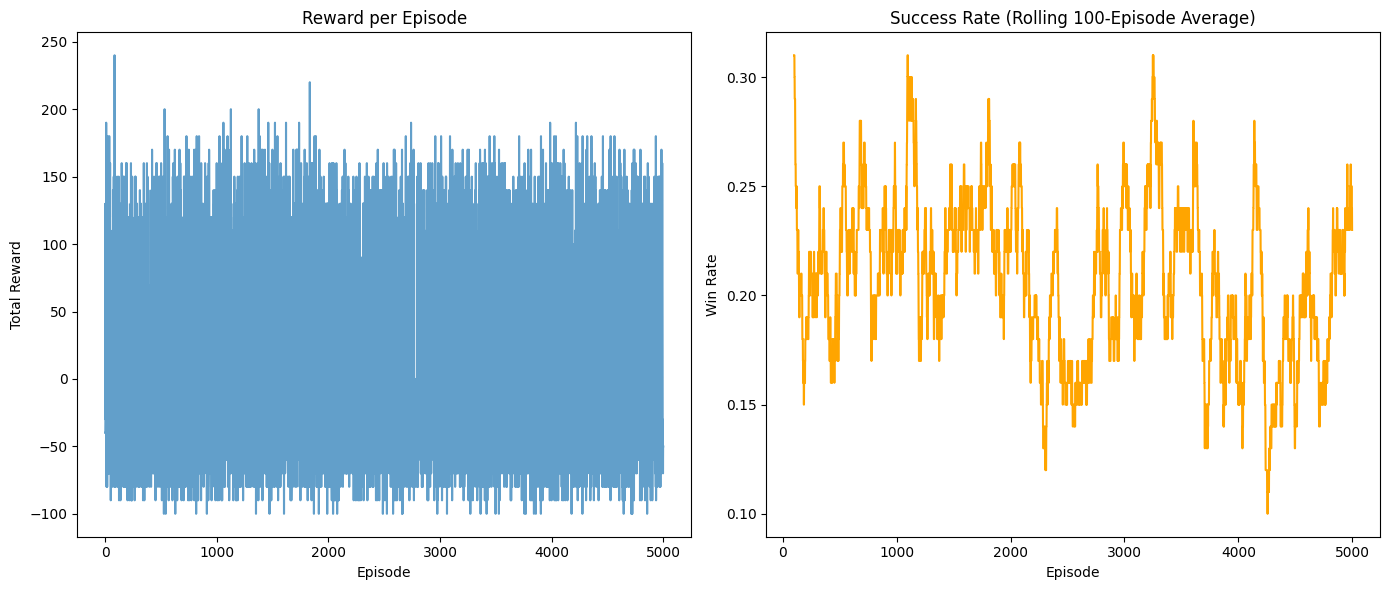

Evaluation: 100%|██████████| 2000/2000 [00:05<00:00, 372.27it/s]


Evaluation result (2000 games):
 Success rate: 22.45% | Avg wrong: 5.53
Final Score: -54861.00
✓ Saved HMMs to hmm_models_final.pkl
✓ Saved RL agent to rl_agent_final.pkl

Done.


In [21]:
def main():
    hmm_path = 'hmm_models_final.pkl'
    train_hmm = False
    episodes = 5000
    save_every = 500

    hmm = HangmanHMM(n_states=5, n_iter=30, seed=42)
    if train_hmm:
        print(f"Retraining HMMs...")
        hmm.train(train_words, verbose=True)
        hmm.save(hmm_path)
    else:
        try:
            hmm.load(hmm_path)
            print(f"Loaded HMMs from {hmm_path}")
        except Exception as e:
            print(f"Failed to load HMM from {hmm_path}: {e}\nRetraining...")
            hmm.train(train_words, verbose=True)
            hmm.save(hmm_path)

    env = HangmanEnvironment(train_words)
    agent = HangmanRLAgent(hmm)
    print(f'\nStarting RL training run ({episodes} episodes)...')
    stats = train_agent(agent, env, num_episodes=episodes, save_every=save_every)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(stats['episode_rewards'], alpha=0.7)
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    window = 100
    success_moving_avg = pd.Series(stats['wins']).rolling(window).mean()
    plt.subplot(1, 2, 2)
    plt.plot(success_moving_avg, color='orange')
    plt.title(f'Success Rate (Rolling {window}-Episode Average)')
    plt.xlabel('Episode')
    plt.ylabel('Win Rate')

    plt.tight_layout()
    plt.show()


    eval_res = evaluate_agent(agent, test_words, num_games=2000)
    print('\nEvaluation result (2000 games):')
    print(f" Success rate: {eval_res['success_rate']*100:.2f}% | Avg wrong: {eval_res['avg_wrong_guesses']:.2f}")

    final_score = (eval_res['success_rate'] * 2000) \
      - (eval_res['total_wrong_guesses'] * 5) \
      - (eval_res['total_repeated_guesses'] * 2)
    print(f"Final Score: {final_score:.2f}")

    hmm.save('hmm_models_final.pkl')
    agent.save('rl_agent_final.pkl')

    print('\nDone.')

if __name__ == '__main__':
    main()